#### Notes on current version:
**Done**:

- $\checkmark$ Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!

**To do:**
  
- Implement Regression

- Implement Feature Map

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [19]:
# Robustness Parameter
robustness_parameter = .3

# Reconfiguration Parameters
N_Reconfigurations = 20
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = .5

# Training meta-parameters
Pre_Epochs = 50
Full_Epochs = 600

# Depth & Height of first Reconfiguration
Initial_Depth = 20
Initial_Height = 10

# Depth & Height Per Reconfiguration
Depth_per_reconfig = 20
Height_per_reconfig = 5

# Number of Datapoints
N_data = 10**3
Train_step_proportion = .7


# Unknown Function
def unknown_f(x):
    return .1*x + .1*(x**2) + x*np.exp(-np.abs(x)) + np.sin(4*x + 3*x**2) #+ x % 1

### Run External/Auxiliary Notebooks

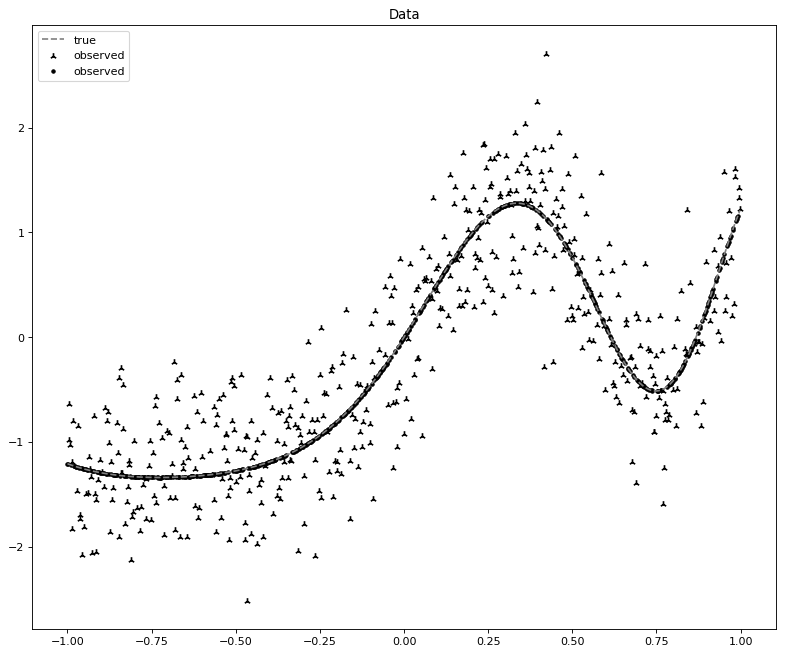

In [20]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=200,
                                                height=100,
                                                depth=10,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark = predictions_OLS_Benchmark.reshape(-1,)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)
predictions_OLS_Benchmark_test = predictions_OLS_Benchmark_test.reshape(-1,)

Pre-trained benchmark model does not exist: Training.
Epoch 1/200
16/16 [==============================] - 0s 4ms/step - loss: 0.8872 - mse: 1.1029 - mae: 0.8872 - mape: 343.2589
Epoch 2/200
16/16 [==============================] - 0s 3ms/step - loss: 0.8824 - mse: 1.0865 - mae: 0.8824 - mape: 349.5361
Epoch 3/200
16/16 [==============================] - 0s 3ms/step - loss: 0.8688 - mse: 1.0602 - mae: 0.8688 - mape: 334.2631
Epoch 4/200
16/16 [==============================] - 0s 3ms/step - loss: 0.6476 - mse: 0.6245 - mae: 0.6476 - mape: 581.0273
Epoch 5/200
16/16 [==============================] - 0s 3ms/step - loss: 0.5790 - mse: 0.5294 - mae: 0.5790 - mape: 487.7030
Epoch 6/200
16/16 [==============================] - 0s 3ms/step - loss: 0.5741 - mse: 0.5181 - mae: 0.5741 - mape: 579.4240
Epoch 7/200
16/16 [==============================] - 0s 3ms/step - loss: 0.5725 - mse: 0.5164 - mae: 0.5725 - mape: 526.2154
Epoch 8/200
16/16 [==============================] - 0s 3ms/step - loss

16/16 [==============================] - 0s 2ms/step - loss: 0.4832 - mse: 0.3869 - mae: 0.4832 - mape: 495.0192
Epoch 66/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4902 - mse: 0.3986 - mae: 0.4902 - mape: 524.1141
Epoch 67/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4757 - mse: 0.3795 - mae: 0.4757 - mape: 435.1716
Epoch 68/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4823 - mse: 0.3943 - mae: 0.4823 - mape: 468.5170
Epoch 69/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4968 - mse: 0.4163 - mae: 0.4968 - mape: 518.2929
Epoch 70/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4838 - mse: 0.3870 - mae: 0.4838 - mape: 402.0501
Epoch 71/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4778 - mse: 0.3865 - mae: 0.4778 - mape: 574.0097
Epoch 72/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4873 - mse: 0.3965 - mae: 0.4873 - mape: 430.0987
Epoch

16/16 [==============================] - 0s 2ms/step - loss: 0.4737 - mse: 0.3760 - mae: 0.4737 - mape: 460.4407
Epoch 130/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4980 - mse: 0.4150 - mae: 0.4980 - mape: 471.5657
Epoch 131/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4955 - mse: 0.4079 - mae: 0.4955 - mape: 459.7083
Epoch 132/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4831 - mse: 0.3854 - mae: 0.4831 - mape: 516.7805
Epoch 133/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4770 - mse: 0.3869 - mae: 0.4770 - mape: 478.0887
Epoch 134/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4974 - mse: 0.4103 - mae: 0.4974 - mape: 444.5793
Epoch 135/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4974 - mse: 0.4107 - mae: 0.4974 - mape: 498.5863
Epoch 136/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4771 - mse: 0.3836 - mae: 0.4771 - mape: 440.159

16/16 [==============================] - 0s 3ms/step - loss: 0.5209 - mse: 0.4359 - mae: 0.5209 - mape: 643.1477
Epoch 194/200
16/16 [==============================] - 0s 3ms/step - loss: 0.5078 - mse: 0.4236 - mae: 0.5078 - mape: 660.4882
Epoch 195/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4950 - mse: 0.4044 - mae: 0.4950 - mape: 642.4547
Epoch 196/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4922 - mse: 0.4048 - mae: 0.4922 - mape: 616.0018
Epoch 197/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4742 - mse: 0.3780 - mae: 0.4742 - mape: 495.3858
Epoch 198/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4740 - mse: 0.3790 - mae: 0.4740 - mape: 423.3329
Epoch 199/200
16/16 [==============================] - 0s 4ms/step - loss: 0.4808 - mse: 0.3816 - mae: 0.4808 - mape: 431.4370
Epoch 200/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4809 - mse: 0.3823 - mae: 0.4809 - mape: 470.576

## Get base regression model for NEU

In [6]:
if os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS = predictions_OLS.reshape(-1,)
predictions_OLS_test = regression_basic.predict(data_x_test)

Pre-trained benchmark model does not exist: Training.
Epoch 1/200
16/16 - 0s - loss: 73.4857 - mse: 0.5439 - mae: 0.4404 - mape: 149.1925
Epoch 2/200
16/16 - 0s - loss: 72.1047 - mse: 0.4337 - mae: 0.3868 - mape: 310.7353
Epoch 3/200
16/16 - 0s - loss: 70.1037 - mse: 0.2963 - mae: 0.3087 - mape: 278.4005
Epoch 4/200
16/16 - 0s - loss: 70.2936 - mse: 0.2960 - mae: 0.3187 - mape: 301.0260
Epoch 5/200
16/16 - 0s - loss: 69.3217 - mse: 0.2447 - mae: 0.2761 - mape: 269.1214
Epoch 6/200
16/16 - 0s - loss: 69.5861 - mse: 0.2557 - mae: 0.2872 - mape: 281.3044
Epoch 7/200
16/16 - 0s - loss: 69.1770 - mse: 0.2311 - mae: 0.2709 - mape: 298.3378
Epoch 8/200
16/16 - 0s - loss: 68.9631 - mse: 0.2215 - mae: 0.2607 - mape: 308.9081
Epoch 9/200
16/16 - 0s - loss: 69.4254 - mse: 0.2536 - mae: 0.2788 - mape: 260.5554
Epoch 10/200
16/16 - 0s - loss: 69.3791 - mse: 0.2442 - mae: 0.2781 - mape: 298.0713
Epoch 11/200
16/16 - 0s - loss: 69.0713 - mse: 0.2237 - mae: 0.2659 - mape: 299.7599
Epoch 12/200
16/16 -

Epoch 97/200
16/16 - 0s - loss: 68.5914 - mse: 0.2029 - mae: 0.2444 - mape: 240.3724
Epoch 98/200
16/16 - 0s - loss: 68.8435 - mse: 0.2160 - mae: 0.2547 - mape: 287.2473
Epoch 99/200
16/16 - 0s - loss: 68.6960 - mse: 0.2049 - mae: 0.2490 - mape: 221.8146
Epoch 100/200
16/16 - 0s - loss: 68.4850 - mse: 0.1935 - mae: 0.2417 - mape: 236.5366
Epoch 101/200
16/16 - 0s - loss: 68.3980 - mse: 0.1876 - mae: 0.2365 - mape: 205.1097
Epoch 102/200
16/16 - 0s - loss: 68.4608 - mse: 0.1911 - mae: 0.2387 - mape: 211.7345
Epoch 103/200
16/16 - 0s - loss: 68.3294 - mse: 0.1855 - mae: 0.2336 - mape: 220.9918
Epoch 104/200
16/16 - 0s - loss: 68.4984 - mse: 0.1912 - mae: 0.2409 - mape: 265.1671
Epoch 105/200
16/16 - 0s - loss: 68.4646 - mse: 0.1938 - mae: 0.2390 - mape: 227.5484
Epoch 106/200
16/16 - 0s - loss: 68.4058 - mse: 0.1893 - mae: 0.2367 - mape: 218.0792
Epoch 107/200
16/16 - 0s - loss: 68.3859 - mse: 0.1900 - mae: 0.2365 - mape: 228.7130
Epoch 108/200
16/16 - 0s - loss: 68.8228 - mse: 0.2138 - 

Epoch 193/200
16/16 - 0s - loss: 68.6919 - mse: 0.2046 - mae: 0.2500 - mape: 267.3697
Epoch 194/200
16/16 - 0s - loss: 69.1778 - mse: 0.2443 - mae: 0.2678 - mape: 345.4774
Epoch 195/200
16/16 - 0s - loss: 68.6101 - mse: 0.1990 - mae: 0.2464 - mape: 222.3925
Epoch 196/200
16/16 - 0s - loss: 68.6331 - mse: 0.2039 - mae: 0.2459 - mape: 275.4169
Epoch 197/200
16/16 - 0s - loss: 68.5522 - mse: 0.1979 - mae: 0.2430 - mape: 250.9160
Epoch 198/200
16/16 - 0s - loss: 68.4660 - mse: 0.1913 - mae: 0.2392 - mape: 245.2186
Epoch 199/200
16/16 - 0s - loss: 68.4367 - mse: 0.1899 - mae: 0.2380 - mape: 247.3280
Epoch 200/200
16/16 - 0s - loss: 68.5116 - mse: 0.1956 - mae: 0.2417 - mape: 247.0422
Base Regressor-Model: Saving
INFO:tensorflow:Assets written to: ./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/assets
Base Regressor-Model: Saved


### Generate Plots - Visualization

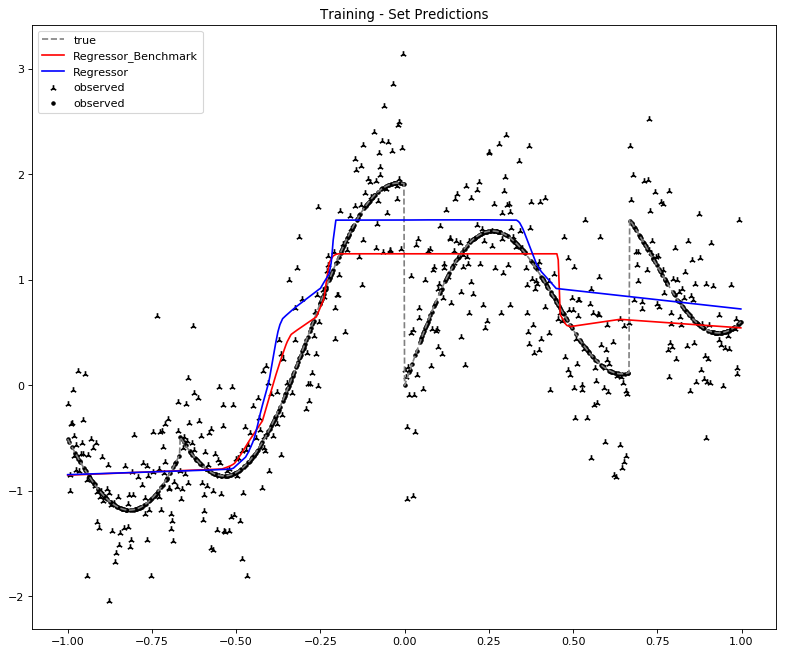

In [7]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test.reshape(-1,)), color = 'red', label='Regressor_Benchmark')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [8]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
NEU_OLS_prediction = NEU_OLS_prediction.reshape(-1,)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS_prediction_test.reshape(-1,)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained model does not exist: Training.
0.8205891129748967
0.05
0.702178181766932
0.1
2.7056306819205957
0.15
1.8408703764691814
0.2
2.5878424264968043
0.25
2.557511010094995
0.3
0.482539188829798
0.35
0.31110791501497936
0.4
0.6361209164441095
0.45
2.4404993502356422
0.5
0.5711237438488168
0.55
2.001719885260312
0.6
1.1646540405059305
0.65
1.987733938801626
0.7
1.0184274865074356
0.75
1.7935954705923123
0.8
0.6782856222853862
0.85
1.4601040813358854
0.9
0.5104924927757208
0.95
0.7799162025724644
1.0
Complete: Pre-Training Readout Map on Input x Output Space!
Saving Pre-Trained Readout on Input x Output Space!
INFO:tensorflow:Assets written to: ./outputs/models/NEU/Greedy_Initializations/assets
(Full-)Model does not exist: Training.
Epoch 1/600
16/16 [==============================] - 0s 14ms/step - loss: 37.6051 - mse: 0.5008 - mae: 0.5402
Epoch 2/600
16/16 [==============================] - 0s 15ms/step - loss: 37.0363 - mse: 0.4040 - mae: 0.4997
Epoch 3/600
16/16 [==============

16/16 [==============================] - 0s 17ms/step - loss: 36.7769 - mse: 0.3828 - mae: 0.4764
Epoch 69/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7911 - mse: 0.3857 - mae: 0.4750
Epoch 70/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7897 - mse: 0.3841 - mae: 0.4765
Epoch 71/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6995 - mse: 0.3743 - mae: 0.4693
Epoch 72/600
16/16 [==============================] - 0s 15ms/step - loss: 36.8747 - mse: 0.3898 - mae: 0.4855
Epoch 73/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7389 - mse: 0.3777 - mae: 0.4707
Epoch 74/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6938 - mse: 0.3738 - mae: 0.4696
Epoch 75/600
16/16 [==============================] - 0s 17ms/step - loss: 36.8178 - mse: 0.3830 - mae: 0.4782
Epoch 76/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7697 - mse: 0.3839 - mae: 0.4735
Epoch 77/600
1

16/16 [==============================] - 0s 14ms/step - loss: 36.7065 - mse: 0.3775 - mae: 0.4714
Epoch 142/600
16/16 [==============================] - 0s 14ms/step - loss: 36.7238 - mse: 0.3776 - mae: 0.4711
Epoch 143/600
16/16 [==============================] - 0s 14ms/step - loss: 36.7245 - mse: 0.3767 - mae: 0.4713
Epoch 144/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7111 - mse: 0.3735 - mae: 0.4697
Epoch 145/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7377 - mse: 0.3830 - mae: 0.4718
Epoch 146/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7557 - mse: 0.3800 - mae: 0.4744
Epoch 147/600
16/16 [==============================] - 0s 18ms/step - loss: 36.6597 - mse: 0.3715 - mae: 0.4650
Epoch 148/600
16/16 [==============================] - 0s 18ms/step - loss: 36.7010 - mse: 0.3758 - mae: 0.4689
Epoch 149/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7310 - mse: 0.3763 - mae: 0.4713
Epoch 

16/16 [==============================] - 0s 16ms/step - loss: 36.6619 - mse: 0.3727 - mae: 0.4665
Epoch 215/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6954 - mse: 0.3730 - mae: 0.4668
Epoch 216/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7005 - mse: 0.3762 - mae: 0.4670
Epoch 217/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7411 - mse: 0.3765 - mae: 0.4723
Epoch 218/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6977 - mse: 0.3737 - mae: 0.4705
Epoch 219/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7347 - mse: 0.3787 - mae: 0.4717
Epoch 220/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6841 - mse: 0.3709 - mae: 0.4675
Epoch 221/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6690 - mse: 0.3685 - mae: 0.4672
Epoch 222/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7718 - mse: 0.3774 - mae: 0.4750
Epoch 

16/16 [==============================] - 0s 15ms/step - loss: 36.7650 - mse: 0.3801 - mae: 0.4738
Epoch 288/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6560 - mse: 0.3727 - mae: 0.4648
Epoch 289/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6909 - mse: 0.3759 - mae: 0.4677
Epoch 290/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7523 - mse: 0.3795 - mae: 0.4726
Epoch 291/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6219 - mse: 0.3701 - mae: 0.4630
Epoch 292/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7608 - mse: 0.3824 - mae: 0.4725
Epoch 293/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6693 - mse: 0.3745 - mae: 0.4645
Epoch 294/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7094 - mse: 0.3787 - mae: 0.4705
Epoch 295/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7193 - mse: 0.3769 - mae: 0.4706
Epoch 

16/16 [==============================] - 0s 16ms/step - loss: 36.7281 - mse: 0.3749 - mae: 0.4715
Epoch 361/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6792 - mse: 0.3713 - mae: 0.4667
Epoch 362/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7341 - mse: 0.3777 - mae: 0.4717
Epoch 363/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7139 - mse: 0.3750 - mae: 0.4694
Epoch 364/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6860 - mse: 0.3744 - mae: 0.4666
Epoch 365/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6649 - mse: 0.3752 - mae: 0.4643
Epoch 366/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6868 - mse: 0.3729 - mae: 0.4668
Epoch 367/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7165 - mse: 0.3728 - mae: 0.4704
Epoch 368/600
16/16 [==============================] - 0s 17ms/step - loss: 36.7436 - mse: 0.3786 - mae: 0.4708
Epoch 

16/16 [==============================] - 0s 16ms/step - loss: 36.6820 - mse: 0.3726 - mae: 0.4673
Epoch 434/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7007 - mse: 0.3752 - mae: 0.4691
Epoch 435/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6899 - mse: 0.3746 - mae: 0.4671
Epoch 436/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6966 - mse: 0.3725 - mae: 0.4682
Epoch 437/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7216 - mse: 0.3719 - mae: 0.4699
Epoch 438/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7101 - mse: 0.3794 - mae: 0.4709
Epoch 439/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6342 - mse: 0.3683 - mae: 0.4626
Epoch 440/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7471 - mse: 0.3761 - mae: 0.4723
Epoch 441/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7398 - mse: 0.3808 - mae: 0.4735
Epoch 

16/16 [==============================] - 0s 16ms/step - loss: 36.6969 - mse: 0.3724 - mae: 0.4692
Epoch 507/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7088 - mse: 0.3753 - mae: 0.4696
Epoch 508/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6742 - mse: 0.3728 - mae: 0.4660
Epoch 509/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7492 - mse: 0.3791 - mae: 0.4721
Epoch 510/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6654 - mse: 0.3737 - mae: 0.4660
Epoch 511/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7181 - mse: 0.3752 - mae: 0.4709
Epoch 512/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6848 - mse: 0.3744 - mae: 0.4668
Epoch 513/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6671 - mse: 0.3729 - mae: 0.4650
Epoch 514/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7963 - mse: 0.3842 - mae: 0.4761
Epoch 

16/16 [==============================] - 0s 16ms/step - loss: 36.6452 - mse: 0.3719 - mae: 0.4642
Epoch 580/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7220 - mse: 0.3824 - mae: 0.4689
Epoch 581/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6489 - mse: 0.3727 - mae: 0.4640
Epoch 582/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6297 - mse: 0.3696 - mae: 0.4618
Epoch 583/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6816 - mse: 0.3735 - mae: 0.4661
Epoch 584/600
16/16 [==============================] - 0s 16ms/step - loss: 36.7293 - mse: 0.3732 - mae: 0.4695
Epoch 585/600
16/16 [==============================] - 0s 15ms/step - loss: 36.6948 - mse: 0.3734 - mae: 0.4679
Epoch 586/600
16/16 [==============================] - 0s 16ms/step - loss: 36.6561 - mse: 0.3721 - mae: 0.4649
Epoch 587/600
16/16 [==============================] - 0s 15ms/step - loss: 36.7171 - mse: 0.3814 - mae: 0.4689
Epoch 

### Generate Plots - Visualization

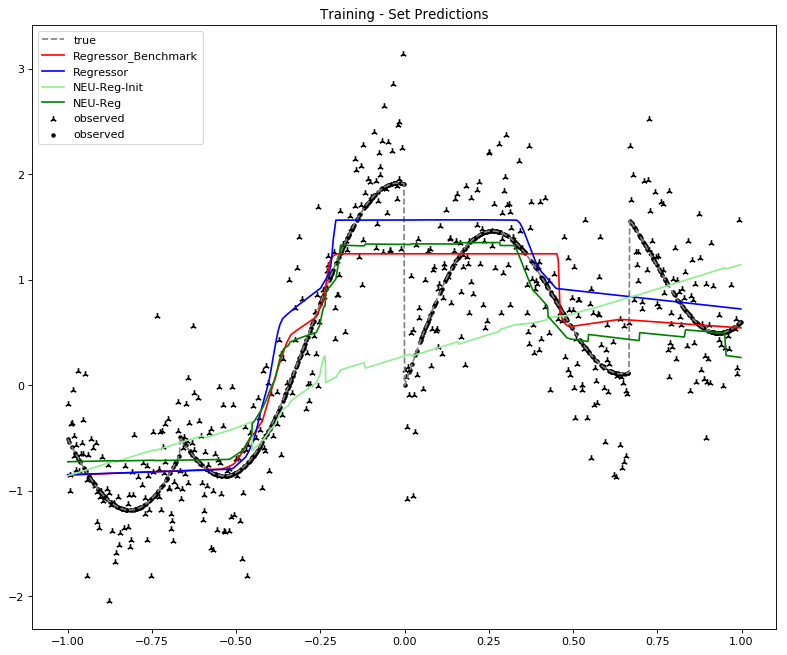

In [9]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='Regressor_Benchmark')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test.reshape(-1,)), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

---
---
---

# Benchmark Models

In [10]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    # Basic Model
    regression_basic_nonrobust = get_base_model_Regression_nonrobust(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    # NEU Version
    Deep_GLd = build_reconfiguration_GLd(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')

    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
Deep_GLd_prediction = Deep_GLd_prediction.reshape(-1,)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
Deep_GLd_prediction_test = Deep_GLd_prediction_test.reshape(-1,)
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

GLd-Nets Model does not exist: Training.
Epoch 1/200
16/16 - 0s - loss: 0.4414 - mse: 0.5482 - mae: 0.4414 - mape: 168.9454
Epoch 2/200
16/16 - 0s - loss: 0.4432 - mse: 0.5457 - mae: 0.4432 - mape: 157.7772
Epoch 3/200
16/16 - 0s - loss: 0.4412 - mse: 0.5461 - mae: 0.4412 - mape: 171.7923
Epoch 4/200
16/16 - 0s - loss: 0.4402 - mse: 0.5461 - mae: 0.4402 - mape: 189.3921
Epoch 5/200
16/16 - 0s - loss: 0.4395 - mse: 0.5423 - mae: 0.4395 - mape: 171.6627
Epoch 6/200
16/16 - 0s - loss: 0.4409 - mse: 0.5470 - mae: 0.4409 - mape: 185.1742
Epoch 7/200
16/16 - 0s - loss: 0.4391 - mse: 0.5436 - mae: 0.4391 - mape: 188.8831
Epoch 8/200
16/16 - 0s - loss: 0.4998 - mse: 0.8199 - mae: 0.4998 - mape: 159.1705
Epoch 9/200
16/16 - 0s - loss: 0.4430 - mse: 0.5446 - mae: 0.4430 - mape: 134.8246
Epoch 10/200
16/16 - 0s - loss: 0.4171 - mse: 0.5087 - mae: 0.4171 - mape: 116.5834
Epoch 11/200
16/16 - 0s - loss: 0.3130 - mse: 0.3169 - mae: 0.3130 - mape: 289.7679
Epoch 12/200
16/16 - 0s - loss: 0.2886 - mse

16/16 - 0s - loss: 0.2576 - mse: 0.2137 - mae: 0.2576 - mape: 325.5692
Epoch 99/200
16/16 - 0s - loss: 0.2541 - mse: 0.2133 - mae: 0.2541 - mape: 313.1201
Epoch 100/200
16/16 - 0s - loss: 0.2508 - mse: 0.2086 - mae: 0.2508 - mape: 316.8402
Epoch 101/200
16/16 - 0s - loss: 0.2478 - mse: 0.1996 - mae: 0.2478 - mape: 247.2146
Epoch 102/200
16/16 - 0s - loss: 0.2532 - mse: 0.2134 - mae: 0.2532 - mape: 300.3966
Epoch 103/200
16/16 - 0s - loss: 0.2515 - mse: 0.2079 - mae: 0.2515 - mape: 261.9774
Epoch 104/200
16/16 - 0s - loss: 0.2444 - mse: 0.2009 - mae: 0.2444 - mape: 248.0643
Epoch 105/200
16/16 - 0s - loss: 0.2504 - mse: 0.2072 - mae: 0.2504 - mape: 246.6956
Epoch 106/200
16/16 - 0s - loss: 0.2450 - mse: 0.2009 - mae: 0.2450 - mape: 280.1960
Epoch 107/200
16/16 - 0s - loss: 0.2491 - mse: 0.2095 - mae: 0.2491 - mape: 281.2616
Epoch 108/200
16/16 - 0s - loss: 0.2573 - mse: 0.2200 - mae: 0.2573 - mape: 182.7830
Epoch 109/200
16/16 - 0s - loss: 0.2511 - mse: 0.2100 - mae: 0.2511 - mape: 251.

Epoch 195/200
16/16 - 0s - loss: 0.2579 - mse: 0.2158 - mae: 0.2579 - mape: 318.3102
Epoch 196/200
16/16 - 0s - loss: 0.2548 - mse: 0.2117 - mae: 0.2548 - mape: 232.5386
Epoch 197/200
16/16 - 0s - loss: 0.2460 - mse: 0.2015 - mae: 0.2460 - mape: 301.6977
Epoch 198/200
16/16 - 0s - loss: 0.2452 - mse: 0.1999 - mae: 0.2452 - mape: 237.8893
Epoch 199/200
16/16 - 0s - loss: 0.2402 - mse: 0.1942 - mae: 0.2402 - mape: 260.3466
Epoch 200/200
16/16 - 0s - loss: 0.2410 - mse: 0.1959 - mae: 0.2410 - mape: 257.5353
Epoch 1/600
16/16 [==============================] - 0s 2ms/step - loss: 2.1269 - mse: 2.1269 - mae: 1.2654
Epoch 2/600
16/16 [==============================] - 0s 2ms/step - loss: 1.9572 - mse: 1.9572 - mae: 1.2120
Epoch 3/600
16/16 [==============================] - 0s 2ms/step - loss: 1.8361 - mse: 1.8361 - mae: 1.1713
Epoch 4/600
16/16 [==============================] - 0s 2ms/step - loss: 1.7292 - mse: 1.7292 - mae: 1.1343
Epoch 5/600
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 3ms/step - loss: 0.6059 - mse: 0.6059 - mae: 0.6391
Epoch 72/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6043 - mse: 0.6043 - mae: 0.6380
Epoch 73/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6027 - mse: 0.6027 - mae: 0.6371
Epoch 74/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6011 - mse: 0.6011 - mae: 0.6361
Epoch 75/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5995 - mse: 0.5995 - mae: 0.6351
Epoch 76/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5981 - mse: 0.5981 - mae: 0.6343
Epoch 77/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5967 - mse: 0.5967 - mae: 0.6335
Epoch 78/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5954 - mse: 0.5954 - mae: 0.6327
Epoch 79/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5942 - mse: 0.5942 - mae: 0.6319
Epoch 80/600
16/16 [============

16/16 [==============================] - 0s 2ms/step - loss: 0.5625 - mse: 0.5625 - mae: 0.6090
Epoch 146/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5622 - mse: 0.5622 - mae: 0.6088
Epoch 147/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5620 - mse: 0.5620 - mae: 0.6086
Epoch 148/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5618 - mse: 0.5618 - mae: 0.6084
Epoch 149/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5616 - mse: 0.5616 - mae: 0.6083
Epoch 150/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5614 - mse: 0.5614 - mae: 0.6081
Epoch 151/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5612 - mse: 0.5612 - mae: 0.6079
Epoch 152/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5610 - mse: 0.5610 - mae: 0.6077
Epoch 153/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5608 - mse: 0.5608 - mae: 0.6076
Epoch 154/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.5517 - mse: 0.5517 - mae: 0.5996
Epoch 220/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5516 - mse: 0.5516 - mae: 0.5995
Epoch 221/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5515 - mse: 0.5515 - mae: 0.5994
Epoch 222/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5514 - mse: 0.5514 - mae: 0.5993
Epoch 223/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5513 - mse: 0.5513 - mae: 0.5992
Epoch 224/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5512 - mse: 0.5512 - mae: 0.5992
Epoch 225/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5511 - mse: 0.5511 - mae: 0.5991
Epoch 226/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5511 - mse: 0.5511 - mae: 0.5990
Epoch 227/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5509 - mse: 0.5509 - mae: 0.5988
Epoch 228/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.5462 - mse: 0.5462 - mae: 0.5946
Epoch 294/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5461 - mse: 0.5461 - mae: 0.5946
Epoch 295/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5461 - mse: 0.5461 - mae: 0.5945
Epoch 296/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5460 - mse: 0.5460 - mae: 0.5944
Epoch 297/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5460 - mse: 0.5460 - mae: 0.5944
Epoch 298/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5459 - mse: 0.5459 - mae: 0.5944
Epoch 299/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5458 - mse: 0.5458 - mae: 0.5943
Epoch 300/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5458 - mse: 0.5458 - mae: 0.5943
Epoch 301/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5457 - mse: 0.5457 - mae: 0.5942
Epoch 302/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.5425 - mse: 0.5425 - mae: 0.5915
Epoch 368/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5425 - mse: 0.5425 - mae: 0.5915
Epoch 369/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5424 - mse: 0.5424 - mae: 0.5914
Epoch 370/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5424 - mse: 0.5424 - mae: 0.5914
Epoch 371/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5424 - mse: 0.5424 - mae: 0.5914
Epoch 372/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5423 - mse: 0.5423 - mae: 0.5914
Epoch 373/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5423 - mse: 0.5423 - mae: 0.5914
Epoch 374/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5423 - mse: 0.5423 - mae: 0.5913
Epoch 375/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5422 - mse: 0.5422 - mae: 0.5913
Epoch 376/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.5397 - mse: 0.5397 - mae: 0.5894
Epoch 442/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5397 - mse: 0.5397 - mae: 0.5894
Epoch 443/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5397 - mse: 0.5397 - mae: 0.5893
Epoch 444/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5397 - mse: 0.5397 - mae: 0.5894
Epoch 445/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5396 - mse: 0.5396 - mae: 0.5893
Epoch 446/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5396 - mse: 0.5396 - mae: 0.5893
Epoch 447/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5395 - mse: 0.5395 - mae: 0.5893
Epoch 448/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5395 - mse: 0.5395 - mae: 0.5892
Epoch 449/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5395 - mse: 0.5395 - mae: 0.5892
Epoch 450/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.5373 - mse: 0.5373 - mae: 0.5876
Epoch 516/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5373 - mse: 0.5373 - mae: 0.5876
Epoch 517/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5373 - mse: 0.5373 - mae: 0.5875
Epoch 518/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5372 - mse: 0.5372 - mae: 0.5875
Epoch 519/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5372 - mse: 0.5372 - mae: 0.5875
Epoch 520/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5371 - mse: 0.5371 - mae: 0.5874
Epoch 521/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5371 - mse: 0.5371 - mae: 0.5875
Epoch 522/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5371 - mse: 0.5371 - mae: 0.5874
Epoch 523/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5371 - mse: 0.5371 - mae: 0.5874
Epoch 524/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.5350 - mse: 0.5350 - mae: 0.5858
Epoch 590/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5350 - mse: 0.5350 - mae: 0.5858
Epoch 591/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5349 - mse: 0.5349 - mae: 0.5857
Epoch 592/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5349 - mse: 0.5349 - mae: 0.5857
Epoch 593/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5348 - mse: 0.5348 - mae: 0.5856
Epoch 594/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5348 - mse: 0.5348 - mae: 0.5856
Epoch 595/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5348 - mse: 0.5348 - mae: 0.5856
Epoch 596/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5347 - mse: 0.5347 - mae: 0.5856
Epoch 597/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5348 - mse: 0.5348 - mae: 0.5856
Epoch 598/600
16/16 [===

In [11]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=build_reconfiguration_Ed(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
Deep_Ed_prediction = Deep_Ed_prediction.reshape(-1,)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
Deep_Ed_prediction_test = Deep_Ed_prediction_test.reshape(-1)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Ed-Nets Model does not exist: Training.
Epoch 1/600
16/16 [==============================] - 0s 2ms/step - loss: 1.8012 - mse: 1.8012 - mae: 1.0222
Epoch 2/600
16/16 [==============================] - 0s 2ms/step - loss: 1.2503 - mse: 1.2503 - mae: 0.8874
Epoch 3/600
16/16 [==============================] - 0s 2ms/step - loss: 1.0739 - mse: 1.0739 - mae: 0.8364
Epoch 4/600
16/16 [==============================] - 0s 2ms/step - loss: 0.9865 - mse: 0.9865 - mae: 0.8098
Epoch 5/600
16/16 [==============================] - 0s 2ms/step - loss: 0.9341 - mse: 0.9341 - mae: 0.7926
Epoch 6/600
16/16 [==============================] - 0s 4ms/step - loss: 0.8988 - mse: 0.8988 - mae: 0.7802
Epoch 7/600
16/16 [==============================] - 0s 3ms/step - loss: 0.8733 - mse: 0.8733 - mae: 0.7712
Epoch 8/600
16/16 [==============================] - 0s 2ms/step - loss: 0.8539 - mse: 0.8539 - mae: 0.7640
Epoch 9/600
16/16 [==============================] - 0s 4ms/step - loss: 0.8386 - mse: 0.8386 - 

16/16 [==============================] - 0s 2ms/step - loss: 0.5960 - mse: 0.5960 - mae: 0.6338
Epoch 76/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5944 - mse: 0.5944 - mae: 0.6329
Epoch 77/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5926 - mse: 0.5926 - mae: 0.6318
Epoch 78/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5908 - mse: 0.5908 - mae: 0.6308
Epoch 79/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5891 - mse: 0.5891 - mae: 0.6298
Epoch 80/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5875 - mse: 0.5875 - mae: 0.6287
Epoch 81/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5858 - mse: 0.5858 - mae: 0.6278
Epoch 82/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5842 - mse: 0.5842 - mae: 0.6267
Epoch 83/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5826 - mse: 0.5826 - mae: 0.6258
Epoch 84/600
16/16 [============

16/16 [==============================] - 0s 2ms/step - loss: 0.5279 - mse: 0.5279 - mae: 0.5926
Epoch 150/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5275 - mse: 0.5275 - mae: 0.5923
Epoch 151/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5271 - mse: 0.5271 - mae: 0.5920
Epoch 152/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5268 - mse: 0.5268 - mae: 0.5918
Epoch 153/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5264 - mse: 0.5264 - mae: 0.5915
Epoch 154/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5261 - mse: 0.5261 - mae: 0.5913
Epoch 155/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5258 - mse: 0.5258 - mae: 0.5911
Epoch 156/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5255 - mse: 0.5255 - mae: 0.5909
Epoch 157/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5251 - mse: 0.5251 - mae: 0.5905
Epoch 158/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.5116 - mse: 0.5116 - mae: 0.5804
Epoch 224/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5115 - mse: 0.5115 - mae: 0.5803
Epoch 225/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5113 - mse: 0.5113 - mae: 0.5801
Epoch 226/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5112 - mse: 0.5112 - mae: 0.5801
Epoch 227/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5111 - mse: 0.5111 - mae: 0.5799
Epoch 228/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5110 - mse: 0.5110 - mae: 0.5798
Epoch 229/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5109 - mse: 0.5109 - mae: 0.5798
Epoch 230/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5108 - mse: 0.5108 - mae: 0.5797
Epoch 231/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5106 - mse: 0.5106 - mae: 0.5795
Epoch 232/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.5054 - mse: 0.5054 - mae: 0.5743
Epoch 298/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5053 - mse: 0.5053 - mae: 0.5741
Epoch 299/600
16/16 [==============================] - 0s 4ms/step - loss: 0.5052 - mse: 0.5052 - mae: 0.5741
Epoch 300/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5052 - mse: 0.5052 - mae: 0.5740
Epoch 301/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5051 - mse: 0.5051 - mae: 0.5740
Epoch 302/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5051 - mse: 0.5051 - mae: 0.5739
Epoch 303/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5049 - mse: 0.5049 - mae: 0.5739
Epoch 304/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5049 - mse: 0.5049 - mae: 0.5737
Epoch 305/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5048 - mse: 0.5048 - mae: 0.5736
Epoch 306/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.5008 - mse: 0.5008 - mae: 0.5695
Epoch 372/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5008 - mse: 0.5008 - mae: 0.5697
Epoch 373/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5007 - mse: 0.5007 - mae: 0.5695
Epoch 374/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5007 - mse: 0.5007 - mae: 0.5693
Epoch 375/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5006 - mse: 0.5006 - mae: 0.5694
Epoch 376/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5005 - mse: 0.5005 - mae: 0.5693
Epoch 377/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5005 - mse: 0.5005 - mae: 0.5692
Epoch 378/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5004 - mse: 0.5004 - mae: 0.5692
Epoch 379/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5004 - mse: 0.5004 - mae: 0.5692
Epoch 380/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.4968 - mse: 0.4968 - mae: 0.5649
Epoch 446/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4968 - mse: 0.4968 - mae: 0.5650
Epoch 447/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4967 - mse: 0.4967 - mae: 0.5650
Epoch 448/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4966 - mse: 0.4966 - mae: 0.5649
Epoch 449/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4966 - mse: 0.4966 - mae: 0.5649
Epoch 450/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4966 - mse: 0.4966 - mae: 0.5646
Epoch 451/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4966 - mse: 0.4966 - mae: 0.5648
Epoch 452/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4966 - mse: 0.4966 - mae: 0.5648
Epoch 453/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4964 - mse: 0.4964 - mae: 0.5647
Epoch 454/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.4937 - mse: 0.4937 - mae: 0.5617
Epoch 520/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4937 - mse: 0.4937 - mae: 0.5616
Epoch 521/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4937 - mse: 0.4937 - mae: 0.5615
Epoch 522/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4937 - mse: 0.4937 - mae: 0.5614
Epoch 523/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4936 - mse: 0.4936 - mae: 0.5616
Epoch 524/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4936 - mse: 0.4936 - mae: 0.5615
Epoch 525/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4936 - mse: 0.4936 - mae: 0.5614
Epoch 526/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4935 - mse: 0.4935 - mae: 0.5612
Epoch 527/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4935 - mse: 0.4935 - mae: 0.5613
Epoch 528/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.4911 - mse: 0.4911 - mae: 0.5591
Epoch 594/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4910 - mse: 0.4910 - mae: 0.5591
Epoch 595/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4910 - mse: 0.4910 - mae: 0.5591
Epoch 596/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4909 - mse: 0.4909 - mae: 0.5590
Epoch 597/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4910 - mse: 0.4910 - mae: 0.5591
Epoch 598/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4909 - mse: 0.4909 - mae: 0.5590
Epoch 599/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4909 - mse: 0.4909 - mae: 0.5589
Epoch 600/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4908 - mse: 0.4908 - mae: 0.5590
Ed-Nets Model: Saving
INFO:tensorflow:Assets written to: ./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/assets
Ed-Nets Model: 

## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Train results.

In [12]:
# Quantile Losses 
#-----------------#
Vanilla = np.array([np.mean(np.abs(predictions_OLS_Benchmark  - data_y)),
                   np.min(np.abs(predictions_OLS_Benchmark - data_y)),
                   np.max(np.abs(predictions_OLS_Benchmark  - data_y)),
                   np.mean(np.power(predictions_OLS_Benchmark  - data_y,2)),
                   Robust_MSE_numpy(predictions_OLS_Benchmark,data_y)])

NEU = np.array([np.mean(np.abs(NEU_OLS_prediction  - data_y)),
 np.min(np.abs(NEU_OLS_prediction  - data_y)),
 np.max(np.abs(NEU_OLS_prediction  - data_y)),
 np.mean(np.power(NEU_OLS_prediction  - data_y,2)),
               Robust_MSE_numpy(NEU_OLS_prediction,data_y)])


NEU_Gld = np.array([np.mean(np.abs(Deep_GLd_prediction  - data_y)),
                   np.min(np.abs(Deep_GLd_prediction  - data_y)),
                   np.max(np.abs(Deep_GLd_prediction  - data_y)),
                   np.mean(np.power(Deep_GLd_prediction  - data_y,2)),
                   Robust_MSE_numpy(Deep_GLd_prediction,data_y)])

NEU_Ed = np.array([np.mean(np.abs(Deep_Ed_prediction- data_y)),
                  np.min(np.abs(Deep_Ed_prediction - data_y)),
                  np.max(np.abs(Deep_Ed_prediction - data_y)),
                  np.mean(np.power(Deep_Ed_prediction - data_y,2)),
                  Robust_MSE_numpy(Deep_Ed_prediction,data_y)])



# Write to DataFrame
Results = pd.DataFrame({'Vanilla': Vanilla, 
                        'NEU': NEU,
                        'NEU_GLd': NEU_Gld,
                        'NEU_Ed':NEU_Ed},index={'MAE','MinE','MaxE','MSE','rMSE'})

Results = pd.DataFrame.transpose(Results)

Test results.

In [13]:
# Quantile Losses 
#-----------------#
Vanilla = np.array([np.mean(np.abs(predictions_OLS_Benchmark_test  - data_y_test)),
                   np.min(np.abs(predictions_OLS_Benchmark_test  - data_y_test)),
                   np.max(np.abs(predictions_OLS_Benchmark_test  - data_y_test)),
                   np.mean(np.power(predictions_OLS_Benchmark_test  - data_y_test,2)),
                   Robust_MSE_numpy(predictions_OLS_Benchmark_test,data_y_test)])

NEU = np.array([np.mean(np.abs(NEU_OLS_prediction_test  - data_y_test)),
 np.min(np.abs(NEU_OLS_prediction_test  - data_y_test)),
 np.max(np.abs(NEU_OLS_prediction_test  - data_y_test)),
 np.mean(np.power(NEU_OLS_prediction_test  - data_y_test,2)),
               Robust_MSE_numpy(NEU_OLS_prediction_test,data_y_test)])

NEU_Gld = np.array([np.mean(np.abs(Deep_GLd_prediction_test  - data_y_test)),
                   np.min(np.abs(Deep_GLd_prediction_test  - data_y_test)),
                   np.max(np.abs(Deep_GLd_prediction_test  - data_y_test)),
                   np.mean(np.power(Deep_GLd_prediction_test  - data_y_test,2)),
                   Robust_MSE_numpy(Deep_GLd_prediction_test,data_y_test)])

NEU_Ed = np.array([np.mean(np.abs(Deep_Ed_prediction_test- data_y_test)),
                  np.min(np.abs(Deep_Ed_prediction_test - data_y_test)),
                  np.max(np.abs(Deep_Ed_prediction_test - data_y_test)),
                  np.mean(np.power(Deep_Ed_prediction_test - data_y_test,2)),
                  Robust_MSE_numpy(Deep_Ed_prediction_test,data_y_test)])



# Write to DataFrame
Results_test = pd.DataFrame({'Vanilla': Vanilla, 
                             'NEU': NEU,
                        'NEU_GLd': NEU_Gld,
                        'NEU_Ed':NEU_Ed},index={'MAE','MinE','MaxE','MSE','rMSE'})

Results_test = pd.DataFrame.transpose(Results_test)

# Visualize Predictions

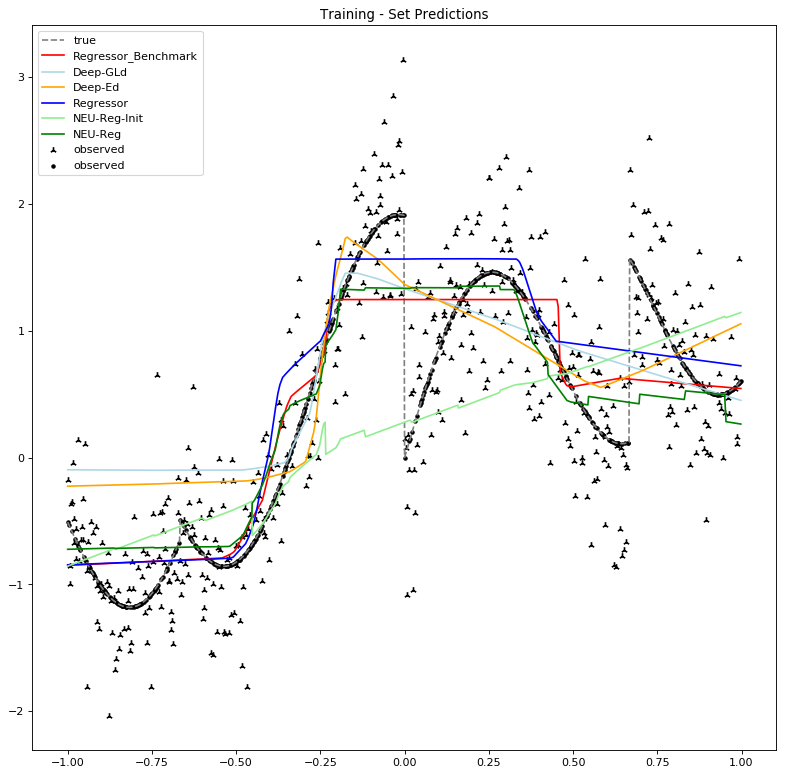

In [14]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='Regressor_Benchmark')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test,color='lightblue',label='Deep-GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test,color='orange',label='Deep-Ed')


# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

 ---

# Report Results

In [15]:
print('Train Results:')
Results.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

Train Results:


,MaxE,rMSE,MAE,MSE,MinE
Vanilla,0.470176,0.001977,2.327278,0.373701,0.494280
NEU,0.471504,0.000966,2.416661,0.378398,0.496292
NEU_GLd,0.585436,0.000776,2.406302,0.534536,0.615333
NEU_Ed,0.558889,0.001865,2.436907,0.490704,0.586766


In [16]:
print('Test Results:')
Results_test.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

Test Results:


,MaxE,rMSE,MAE,MSE,MinE
Vanilla,0.269928,0.000551,1.246170,0.124294,0.277857
NEU,0.284514,0.000534,1.335066,0.139617,0.293642
NEU_GLd,0.427459,0.000938,1.332308,0.288729,0.443585
NEU_Ed,0.431766,0.000973,1.365733,0.256033,0.442360


#### The END

---